# LSTM-RNN

In [1]:
from dotenv import load_dotenv
import sys
import warnings

from __init__ import get_base_path
import data.load_data as load_data
from model_utils import FeatureStore, grab_bag_train_test_split, pad_collate, SignalClassificationDataset, AugmentMinorityClass, DynamicLSTM

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torch.nn.functional as F
import torch.optim as optim

load_dotenv()
warnings.filterwarnings('ignore')


In [2]:
rnn_data_dir = get_base_path() + os.getenv('RNN_DATA_DIR')

In [3]:
random_seed = os.getenv('RANDOM_SEED')
torch.manual_seed(random_seed)

### Load Data

In [4]:
csv_file = load_data.combined_csv
# csv_file = load_data.combined_sample_csv

if os.path.exists(csv_file):
    pass
else:
    load_data.__main__()
df = pd.read_csv(csv_file,index_col=0)

# datatyping that may not be retained by csv
dp = load_data.DataPreprocessor(df)
df = dp.cast_data_types().get_dataframe() 

### Features

In [5]:
features = FeatureStore(df)

X_features = features.R1_waves
y_features = features.y_tertiary
# X_features = ['R1_Phase_A_power_wave']

X = df.loc[:,X_features + ['sample_id']]
y = df.loc[:,y_features]

### Train Test Split

In [6]:
X_train, y_train, X_test, y_test, train_ids, test_ids = grab_bag_train_test_split(X, y, df['sample_id'], return_ids=True)
for i in X_train, y_train, X_test, y_test, train_ids, test_ids:
    print(len(i))

62847
62847
15441
15441
442
110


### MinMaxScaler

In [7]:
scl = MinMaxScaler()
scl.fit(X_train[X_features])
X_train[X_features], X_test[X_features] = scl.transform(X_train[X_features]), scl.transform(X_test[X_features])

### Encoding

* Label Encode Y Classes
* Because we will use zero padding we use a custom label encoder

In [8]:
enc = LabelEncoder()
# enc = NonZeroLabelEncoder()

enc.fit(y_train)
y_train, y_test = enc.transform(y_train), enc.transform(y_test)

for (i, c) in tuple(enumerate(enc.classes_)):
    print(i, c)

0 attack
1 natural
2 no event


### Dataset, DataLoader

Original data are tabular, but LTSM can handle variable signal length instead of a fixed window size, which may be better for learning.

1. Extract individual sequences
2. Apply data augmentation (enhancement is needed for the minority classes)
3. Pack each signal using PyTorch padded sequences, this is more efficient than padding manually, and PyTorch known not to compute padded areas.

In [9]:
y_class_encodings = [i for (i, c) in tuple(enumerate(enc.classes_))]
k_classes = len(y_class_encodings)
x_train_vectors, x_test_vectors, y_train_vectors, y_test_vectors = [],[],[],[]

for encoding in y_class_encodings:
    # subset train and test dataframes for the class label (ie '0'/'attack')
    train_filt, test_filt = y_train == encoding, y_test == encoding
    X_train_filt, X_test_filt = X_train.loc[train_filt], X_test.loc[test_filt]
    train_samples, test_samples = X_train_filt['sample_id'].unique(), X_test_filt['sample_id'].unique()

    # partition result by sample_id, and accumulate vectors
    for sample in train_samples:
        s = X_train_filt.loc[X_train_filt['sample_id'] == sample,X_features]
        x_train_vectors += [torch.tensor(s.to_numpy(),dtype=torch.float)]
        # y_train_vectors += [torch.tensor(np.full(shape=(len(s),),fill_value=encoding),dtype=torch.float)]
        y_train_vectors += [torch.tensor(np.full((1,),fill_value=encoding),dtype=torch.long)]

    for sample in test_samples:
        s = X_test_filt.loc[X_test_filt['sample_id'] == sample,X_features]
        x_test_vectors += [torch.tensor(s.to_numpy(),dtype=torch.float)]
        # y_test_vectors += [torch.tensor(np.full(shape=(len(s),),fill_value=encoding),dtype=torch.float)]
        y_test_vectors += [torch.tensor(np.full((1,),fill_value=encoding),dtype=torch.long)]

for i in x_train_vectors, x_test_vectors, y_train_vectors, y_test_vectors:
    print(len(i))

442
110
442
110


In [10]:
train_dataset = SignalClassificationDataset(signals=x_train_vectors,labels=y_train_vectors)
test_dataset = SignalClassificationDataset(signals=x_test_vectors,labels=y_test_vectors)

### Data Augmentation

* enhance the 'natural' and 'no event' classes to improve training
* each vector is sliced based on a sliding window
* each vector has a small amount of random noise applied

In [11]:
target_classes=[1,2]

transformed_dataset = SignalClassificationDataset(signals=x_train_vectors,labels=y_train_vectors,transform=AugmentMinorityClass(target_classes=target_classes))
transformed_indices = [i for i,(x,y) in enumerate(transformed_dataset) if y.item() in target_classes]
augmented_dataset = Subset(transformed_dataset, transformed_indices)

train_dataset = ConcatDataset((train_dataset,augmented_dataset))
print('size of new augmented training dataset', len(train_dataset))

size of new augmented training dataset 548


In [12]:
# dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)

### LSTM

In [ ]:
# model training hyperparameters
input_size = len(X_features)
output_size = len(y_class_encodings)
hidden_size = 18
num_layers = 7
drop_out = 0.2
n_epochs = 1000
learning_rate = 0.001

In [14]:
model = DynamicLSTM(input_size = input_size,
                    hidden_size = hidden_size,
                    num_layers = num_layers,
                    drop_out = drop_out,
                    output_size = output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training Loop

In [ ]:
model.train()
model.lstm_train(train_dataloader, criterion, optimizer, n_epochs = 1000)

PATH = './dynamic_lstm.pth'
torch.save(model.state_dict(), PATH)

Epoch: 1/50, Step 1, Training Loss 1.0554, Accuracy 0.6250
Epoch: 1/50, Step 11, Training Loss 1.0470, Accuracy 0.6761
Epoch: 1/50, Step 21, Training Loss 1.0341, Accuracy 0.6458
Epoch: 1/50, Step 31, Training Loss 1.0191, Accuracy 0.6331
Epoch: 2/50, Step 1, Training Loss 1.0017, Accuracy 0.6170
Epoch: 2/50, Step 11, Training Loss 1.0287, Accuracy 0.6257
Epoch: 2/50, Step 21, Training Loss 1.0847, Accuracy 0.6210
Epoch: 2/50, Step 31, Training Loss 1.0002, Accuracy 0.6188
Epoch: 3/50, Step 1, Training Loss 0.9795, Accuracy 0.6151
Epoch: 3/50, Step 11, Training Loss 1.0131, Accuracy 0.6132
Epoch: 3/50, Step 21, Training Loss 0.9661, Accuracy 0.6152
Epoch: 3/50, Step 31, Training Loss 0.9955, Accuracy 0.6168
Epoch: 4/50, Step 1, Training Loss 1.0029, Accuracy 0.6139
Epoch: 4/50, Step 11, Training Loss 0.9919, Accuracy 0.6170
Epoch: 4/50, Step 21, Training Loss 0.9447, Accuracy 0.6141
Epoch: 4/50, Step 31, Training Loss 0.9789, Accuracy 0.6112
Epoch: 5/50, Step 1, Training Loss 0.9309, A

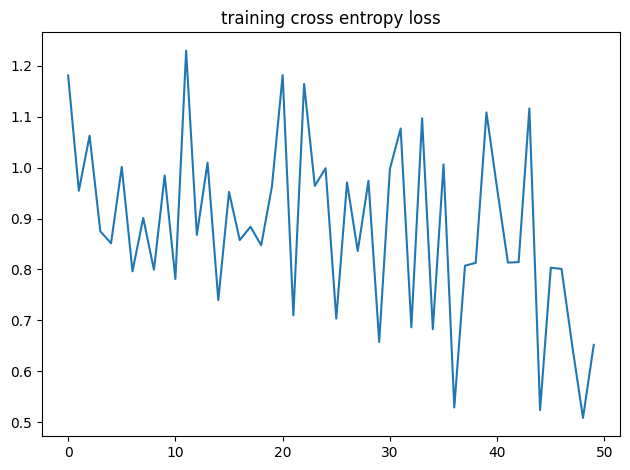

In [17]:
training_loss = [loss.detach().numpy() for loss in model.train_loss_epoch]
plt.plot(training_loss)
plt.title('training cross entropy loss')
plt.tight_layout()

Text(0.5, 1.0, 'training accuracy')

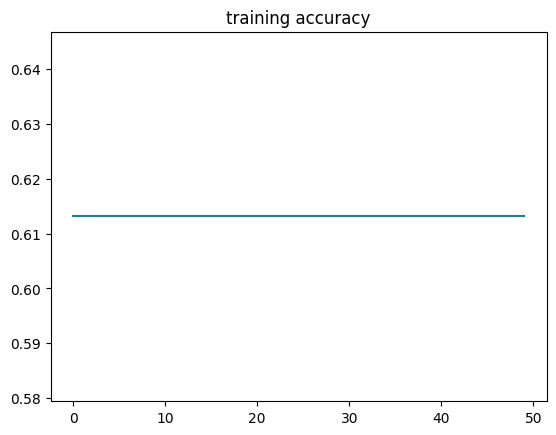

In [18]:
plt.plot(model.train_accuracy_epoch)
plt.title('training accuracy')

In [ ]:
# model = DynamicLSTM()
# model.load_state_dict(torch.load(PATH, weights_only=True))

In [ ]:
# Test - we don't compute gradients
model.eval()
with torch.no_grad():

    n_samples = 0
    n_correct = 0
    test_logits = []
    test_loss = []
    test_pred = []
    test_accuracy = []

    for i, (x, y, x_lens, y_lens) in enumerate(test_dataloader):
        y = y.view(-1)

        out, __ = model(x, x_lens)
        loss = criterion(out, y)
        test_logits == [out]
        test_loss += [loss]
    
        # predict
        __, predicted = torch.max(out, 1)
        test_pred += [predicted]
    
        # track accuracy
        correct = (predicted == y).sum().detach().numpy()
        n_samples += y.size(0)
        n_correct += correct
        test_accuracy += [n_correct / n_samples]
         
        # evaluate periodically
        if (i+1) % 100 != 0:
            print(f"Step {i+1}, Test Loss {loss.item():.4f}, Accuracy {n_correct/n_samples:.4f}")

Epoch: 48/1000, Step 1, Test Loss 0.7972, Accuracy 0.7500
Epoch: 48/1000, Step 2, Test Loss 0.7156, Accuracy 0.7188
Epoch: 48/1000, Step 3, Test Loss 0.5311, Accuracy 0.7917
Epoch: 48/1000, Step 4, Test Loss 0.6035, Accuracy 0.7969
Epoch: 48/1000, Step 5, Test Loss 0.7122, Accuracy 0.7625
Epoch: 48/1000, Step 6, Test Loss 0.7484, Accuracy 0.7292
Epoch: 48/1000, Step 7, Test Loss 0.6186, Accuracy 0.7364


# Evaluation